## Installing package dependencies

In [1]:
# install the necessary libraries
!pip install transformers torch accelerate
!pip install openai-clip
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.4 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=fb40f4538724bb22d997017445711b704faf6062599f59b735b8898ee407cfcb
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00


## Import the required packages

In [3]:
## import packages
import os
import numpy as np
import pickle
import torch
from PIL import Image

import clip
import transformers
from transformers import AutoTokenizer, pipeline

from datasets import load_dataset

## Section 1

### Vector Database creation

Dataset Link: https://huggingface.co/datasets/nateraw/pascal-voc-2012



In [6]:
# Implement the function to create vector database

class VectorDataBase:
    def __init__(self):
        self.vector_data = {}  # A dictionary to store vectors
        self.vector_index = {}  # An indexing structure for retrieval

    def get_vector(self, vector_id):
        """
        Retrieve a vector from the DataBase.

        Args:
            vector_id (str or int): The identifier of the vector.

        Returns:
            numpy.ndarray: The vector data if found, or None if not found.
        """
        return self.vector_data.get(vector_id)[0]

    def get_image(self, vector_id):
        """
        Retrieve a image from the DataBase.

        Args:
            vector_id (str or int): The identifier of the vector.

        Returns:
            numpy.ndarray: Display Image.
        """
        return self.vector_data.get(vector_id)[1]


    def add_vector(self, vector_id, vector, image):
        """
        Add a vector to the store.

        Args:
            vector_id (str or int): A unique identifier for the vector.
            vector (numpy.ndarray): The vector data to be stored.
            image (JPEG): JPEGImage Object.
        """
        self.vector_data[vector_id] = (vector, image)
        if len(self.vector_data) > 1:
          self.update_index(vector_id, vector)


    def update_index(self, vector_id, vector):
        """
        Update the index with the new vector.

        Args:
            vector_id (str or int): The identifier of the vector.
            vector (numpy.ndarray): The vector data.
        """

        for existing_id, (existing_vector, image) in self.vector_data.items():
            similarity = np.dot(vector.squeeze(), existing_vector.squeeze()) / (np.linalg.norm(vector) * np.linalg.norm(existing_vector))
            if existing_id not in self.vector_index:
                self.vector_index[existing_id] = {}
            self.vector_index[existing_id][vector_id] = similarity

    def find_similar_vectors(self, query_vector, num_results=5):
        """
        Find similar vectors to the query vector using brute-force search.

        Args:
            query_vector (numpy.ndarray): The query vector for similarity search.
            num_results (int): The number of similar vectors to return.

        Returns:
            list: A list of (vector_id, similarity_score) tuples for the most similar vectors.
        """
        results = []
        for vector_id, (vector, image) in self.vector_data.items():
            similarity = np.dot(query_vector.cpu().detach().numpy().squeeze(), vector.squeeze()) / (np.linalg.norm(query_vector.cpu().detach().numpy()) * np.linalg.norm(vector))
            results.append((vector_id, similarity))

        # Sort by similarity in descending order
        results.sort(key=lambda x: x[1], reverse=True)

        # Return the top N results
        return results[:num_results]

In [7]:
## Load the dataset

dataset = load_dataset("nateraw/pascal-voc-2012")
pascal_dataset = dataset['train']['image']
pascal_dataset += dataset['val']['image']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1464 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1449 [00:00<?, ? examples/s]

In [8]:
# Create and store the vector database. Feel free to add any helper functions if you need

# Initialize the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def create_and_store(dataset, persist_directory='db'):
    os.makedirs(persist_directory, exist_ok=True)
    # Initialize the vector database
    db = VectorDataBase()

    # Generate image embeddings and store them in the vector database
    for idx, original_image in enumerate(dataset):
        image = preprocess(original_image).unsqueeze(0).to(device)
        with torch.no_grad():
            image_embedding = model.encode_image(image)
            image_embedding = image_embedding.cpu().detach().numpy()
        db.add_vector(idx, image_embedding, original_image)

    # Save the vector database to disk
    with open(os.path.join(persist_directory, 'vector_db.pkl'), 'wb') as f:
        pickle.dump(db, f)

    return db, os.path.join(persist_directory, 'vector_db.pkl')

100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 37.8MiB/s]


In [9]:
vectorDB, Vdbpkl_loc = create_and_store(pascal_dataset)

In [12]:
# Load vectord DB

def loadDB(file_name):
  # Load the vectorDB
  file = open(file_name, 'rb')
  DB = pickle.load(file)
  return DB

## Section 2

Implement search functionlity

In [14]:
# # Load vectorDB

filename = Vdbpkl_loc
vecdb = loadDB(filename)

In [45]:
# Search function

def search(input_query, vectorDB, top_k=5):
  # Implement search functionality
    """
    Find similar vectors to the query vector.

    Args:
        input_query (str): The input query for similarity search.
        vectorDB (VectorDataBase): The number of similar vectors to return.

    Returns:
        list: A list of (vector_id, similarity_score) tuples for the most similar vectors.
    """
    # Encode query text into text embedding
    with torch.no_grad():
        text_embedding = model.encode_text(clip.tokenize([input_query]).to(device))
    relevant_images = vectorDB.find_similar_vectors(text_embedding, num_results=5)
    return relevant_images


In [23]:
input_queries = ["dog is running", "A cat", "man holding a glass of cold drink"]
output_images = []
for input_query in input_queries:
  relevant_images = search(input_query, vectorDB)
  output_images.append(pascal_dataset[relevant_images[0][0]])

dog is running


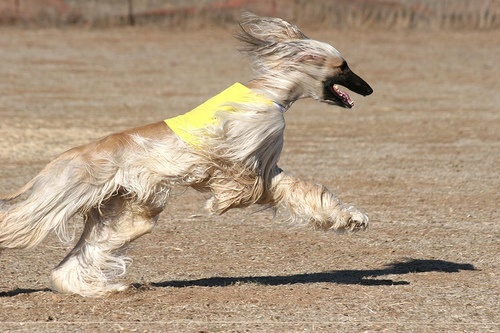

In [27]:
print(input_queries[0])
output_images[0]

A cat


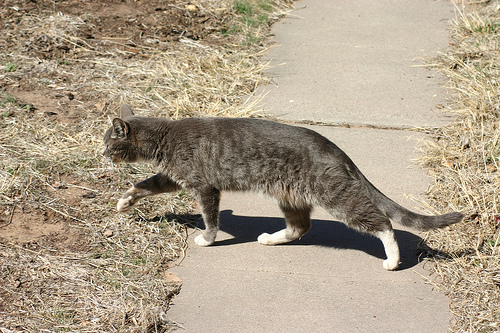

In [28]:
print(input_queries[1])
output_images[1]

man holding a glass of cold drink


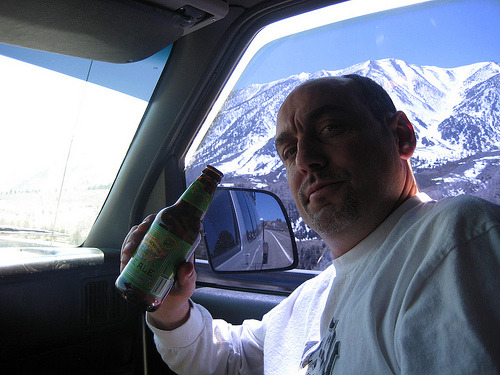

In [29]:
print(input_queries[2])
output_images[2]

## Section 3

LLM output

In [31]:
# hugging face login
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credent

In [32]:
# Load any relevant LLM (You can use huggingface to load and perform other task)

model = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model, use_auth_token=True)

from transformers import pipeline

llama_pipeline = pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [35]:
# Generate the description for the input query

def generate_description(llama_pipeline, input_query):
  """
  Generate a response from the Llama model.

  Parameters:
      llama_pipeline (transformer pipeline): Llama model pipeline
      input_query (str): The user's input/question for the model.

  Returns:
      None: Prints the model's response.
  """
  output_text = ''
  # Add your code her'
  sequences = llama_pipeline(
      input_query,
      do_sample=True,
      top_k=10,
      num_return_sequences=1,
      eos_token_id=tokenizer.eos_token_id,
      max_length=128,
  )
  # print("Response:", sequences[0]['generated_text'])
  output_text = sequences[0]['generated_text']
  return output_text

In [36]:
output_texts = []
for input_query in input_queries:
  prompt = 'For the query: "{input_query}", give a brief description.'
  output_texts.append(generate_description(llama_pipeline, prompt.format(input_query=input_query)))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [40]:
for output_text in output_texts:
  print(output_text)
  print('-'*100)

For the query: "dog is running", give a brief description.

Answer: A dog is a domesticated mammal and a popular pet. It is known for its loyalty and ability to be trained for various tasks. Dogs are often used for hunting, herding, and assisting people with disabilities. They are also known for their playful and energetic nature, and they love to run and play.
----------------------------------------------------------------------------------------------------
For the query: "A cat", give a brief description.

Answer: A cat is a domesticated mammal that is typically small and furry. They are known for their agility and playful personalities, and are often kept as pets. Cats are carnivores and primarily feed on small animals such as mice and birds. They are also known for their ability to purr and meow, and are highly territorial.
----------------------------------------------------------------------------------------------------
For the query: "man holding a glass of cold drink", give 